In [21]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time

# Makine Öğrenmesi ve Model Değerlendirme
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Modeller
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Veri toplama
base_urls = [
    # Türkiye Süper Lig:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # İngiltere Premier Lig:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=186&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # İspanya La Liga:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=40&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # İtalya Serie A:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=189&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # Almanya Bundesliga:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=74&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # Fransa Ligue 1:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=215&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1",
    # Hollanda Eredivisie:
    "https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=157&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1"
]

print("Birden fazla lig için veri toplama başlıyor...")


"""
Birden fazla ligden oyuncu bilgilerini çeker ve bir CSV dosyasına kaydeder.
"""
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

page_number = 1
has_next_page = True
all_players_data = []

for base_url in base_urls:
    print(f"\nLig için veri toplanıyor: {base_url}")
    page_number = 1
    has_next_page = True

    while has_next_page:
        if page_number == 1:
            url = base_url
        else:
            url = f"{base_url}&page={page_number}"

        try:
            print(f"\nSayfa {page_number} işleniyor... URL: {url}")
            time.sleep(3)
            response = requests.get(url, headers=headers)
            if response.status_code == 404:
                print("Sayfa bulunamadı. Son sayfaya ulaşıldı.")
                break

            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'html.parser')

            table = soup.find('table', class_='items')
            if not table:
                print("Tablo bulunamadı!")
                break

            rows = table.find_all('tr', class_=['odd', 'even'])
            if not rows:
                print("Bu sayfada oyuncu bulunamadı.")
                break

            print(f"Bu sayfada bulunan oyuncu sayısı: {len(rows)}")

            for row in rows:
                try:
                    cells = row.find_all('td')
                    # Tablo sütunlarından verileri al
                    rank = cells[0].text.strip() if len(cells) > 0 else "Unknown"
                    name = row.find('td', class_='hauptlink').text.strip()
                    position = cells[4].text.strip() if len(cells) > 4 else "Unknown"
                    age = cells[5].text.strip() if len(cells) > 5 else "Unknown"
                    nationality = cells[6].find('img')['title'] if cells[6].find('img') else "Unknown"
                    club = cells[7].find('a').find('img')['alt'] if cells[7].find('a') and cells[7].find('a').find('img') else cells[7].text.strip()
                    market_value = cells[8].text.strip() if len(cells) > 8 else "Unknown"

                    # İstatistik sütunları
                    matches = cells[9].text.strip() if len(cells) > 9 else "Unknown"
                    goals = cells[10].text.strip() if len(cells) > 10 else "Unknown"
                    own_goals = cells[11].text.strip() if len(cells) > 11 else "Unknown"
                    assists = cells[12].text.strip() if len(cells) > 12 else "Unknown"
                    yellow_cards = cells[13].text.strip() if len(cells) > 13 else "Unknown"
                    second_yellow = cells[14].text.strip() if len(cells) > 14 else "Unknown"
                    red_cards = cells[15].text.strip() if len(cells) > 15 else "Unknown"
                    substitutions = cells[16].text.strip() if len(cells) > 16 else "Unknown"

                    player_data = {
                        "Sıra No": rank,
                        "Oyuncu": name,
                        "Pozisyon": position,
                        "Yaş": age,
                        "Uyruk": nationality,
                        "Kulüp": club,
                        "Piyasa Değeri": market_value,
                        "Maç": matches,
                        "Gol": goals,
                        "Kendi Kalesine Gol": own_goals,
                        "Asist": assists,
                        "Sarı Kart": yellow_cards,
                        "İkinci Sarı Kart": second_yellow,
                        "Kırmızı Kart": red_cards,
                        "Oyuna Girdiği": substitutions
                    }

                    all_players_data.append(player_data)
                    print(f"Oyuncu eklendi: {name}")

                except Exception as e:
                    print(f"Oyuncu verisi işlenirken hata: {str(e)}")
                    continue

            next_page = soup.find('li', class_='tm-pagination__list-item tm-pagination__list-item--icon-next-page')
            if not next_page:
                print("Sonraki sayfa bulunamadı. Son sayfaya ulaşıldı.")
                has_next_page = False
            else:
                page_number += 1

            print(f"Şu ana kadar toplanan toplam oyuncu sayısı: {len(all_players_data)}")

        except requests.exceptions.RequestException as e:
            print(f"HTTP isteği hatası: {str(e)}")
            break
        except Exception as e:
            print(f"Beklenmeyen hata: {str(e)}")
            break

if not all_players_data:
    print("Hiç oyuncu verisi çekilemedi!")
    exit()

# Pandas DataFrame'e aktar ve CSV'ye kaydet
df = pd.DataFrame(all_players_data)
print("\nToplam Tablo:")
print(df.head())
df.to_csv('player_table_multiple_leagues.csv', index=False, encoding='utf-8')
print("\nVeriler 'player_table_multiple_leagues.csv' dosyasına kaydedildi.")


Birden fazla lig için veri toplama başlıyor...

Lig için veri toplanıyor: https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1

Sayfa 1 işleniyor... URL: https://www.transfermarkt.com.tr/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1
Bu sayfada bulunan oyuncu sayısı: 25
Oyuncu eklendi: Erling Haaland
Oyuncu eklendi: Vinicius Junior
Oyuncu eklendi: Lamine Yamal
Oyuncu eklendi: Jude Bellingham
Oyuncu eklendi: Kylian Mbappé
Oyuncu eklendi: Bukayo Saka
Oyuncu eklendi: Florian Wirtz
Oyuncu eklendi: Jamal Musiala
Oyuncu eklendi: Phil Foden
Oyuncu eklendi: Cole Palmer
Oyuncu eklendi: Federico Valverde
Oyuncu eklendi: Rodri
Oyuncu eklendi: Declan Rice
Oyuncu eklendi: Martin Ødegaard
Oyuncu eklendi: Pedri
Oyuncu eklendi: Rodrygo
Oyuncu eklendi: Lautaro Martíne

In [6]:
# (Opsiyonel) Eğer scraping yapmadıysanız, aşağıdaki satırı açın.
# scrape_transfermarkt_data('player_table_multiple_leagues.csv')

data = pd.read_csv('player_table_multiple_leagues.csv')

print("Veri setinin ilk 5 satırı:")
display(data.head())

print("\nVeri seti bilgileri:")
display(data.info())

# Eksik değerlerin sayısı
print("\nEksik değerlerin sayısı:")
print(data.isnull().sum())

# '?' ile işaretlenmiş eksik değerleri NaN yap
data.replace('?', np.nan, inplace=True)

# NaN olan satırları temizle (satır bazında)
data.dropna(inplace=True)
print("\nEksik veriler temizlendi!")

# Veri setinin temel istatistiksel özeti
print("\nVeri setinin istatistiksel özeti:")
display(data.describe())

# İstenmeyen sütunları atmak
columns_to_drop = ['Sıra No', 'Oyuncu', 'Uyruk']
for col in columns_to_drop:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)


Veri setinin ilk 5 satırı:


,Sıra No,Oyuncu,Pozisyon,Yaş,Uyruk,Kulüp,Piyasa Değeri,Maç,Gol,Kendi Kalesine Gol,Asist,Sarı Kart,İkinci Sarı Kart,Kırmızı Kart,Oyuna Girdiği
0,1,Erling Haaland,Santrafor,24,Norveç,Manchester City,200.00 mil. €,35,29,0,2,2,0,0,0
1,2,Vinicius Junior,Sol Kanat,24,Brezilya,Real Madrid,200.00 mil. €,25,14,0,10,9,0,1,3
2,3,Lamine Yamal,Sağ Kanat,17,İspanya,FC Barcelona,180.00 mil. €,28,9,0,14,2,0,0,2
3,4,Jude Bellingham,On Numara,21,İngiltere,Real Madrid,180.00 mil. €,30,10,0,10,7,0,0,1
4,5,Kylian Mbappé,Santrafor,26,Fransa,Real Madrid,160.00 mil. €,31,17,0,3,2,0,0,3



Veri seti bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Sıra No             3040 non-null   int64 
 1   Oyuncu              3040 non-null   object
 2   Pozisyon            3040 non-null   object
 3   Yaş                 3040 non-null   int64 
 4   Uyruk               3040 non-null   object
 5   Kulüp               3040 non-null   object
 6   Piyasa Değeri       3040 non-null   object
 7   Maç                 3040 non-null   int64 
 8   Gol                 3040 non-null   int64 
 9   Kendi Kalesine Gol  3040 non-null   int64 
 10  Asist               3040 non-null   int64 
 11  Sarı Kart           3040 non-null   int64 
 12  İkinci Sarı Kart    3040 non-null   int64 
 13  Kırmızı Kart        3040 non-null   int64 
 14  Oyuna Girdiği       3040 non-null   int64 
dtypes: int64(10), object(5)
memory usage: 356.4+ KB


None


Eksik değerlerin sayısı:
Sıra No               0
Oyuncu                0
Pozisyon              0
Yaş                   0
Uyruk                 0
Kulüp                 0
Piyasa Değeri         0
Maç                   0
Gol                   0
Kendi Kalesine Gol    0
Asist                 0
Sarı Kart             0
İkinci Sarı Kart      0
Kırmızı Kart          0
Oyuna Girdiği         0
dtype: int64

Eksik veriler temizlendi!

Veri setinin istatistiksel özeti:


,Sıra No,Yaş,Maç,Gol,Kendi Kalesine Gol,Asist,Sarı Kart,İkinci Sarı Kart,Kırmızı Kart,Oyuna Girdiği
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000
mean,247.473684,25.516776,16.786184,2.031250,0.039474,1.414474,2.292763,0.043750,0.041118,4.033882
std,145.790148,4.135781,8.415209,3.321732,0.214069,2.112948,2.058014,0.209342,0.205117,3.967933
min,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,120.750000,22.000000,12.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,247.000000,25.000000,18.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,374.000000,28.000000,22.000000,3.000000,0.000000,2.000000,4.000000,0.000000,0.000000,6.000000
max,500.000000,39.000000,39.000000,42.000000,2.000000,17.000000,11.000000,2.000000,2.000000,21.000000


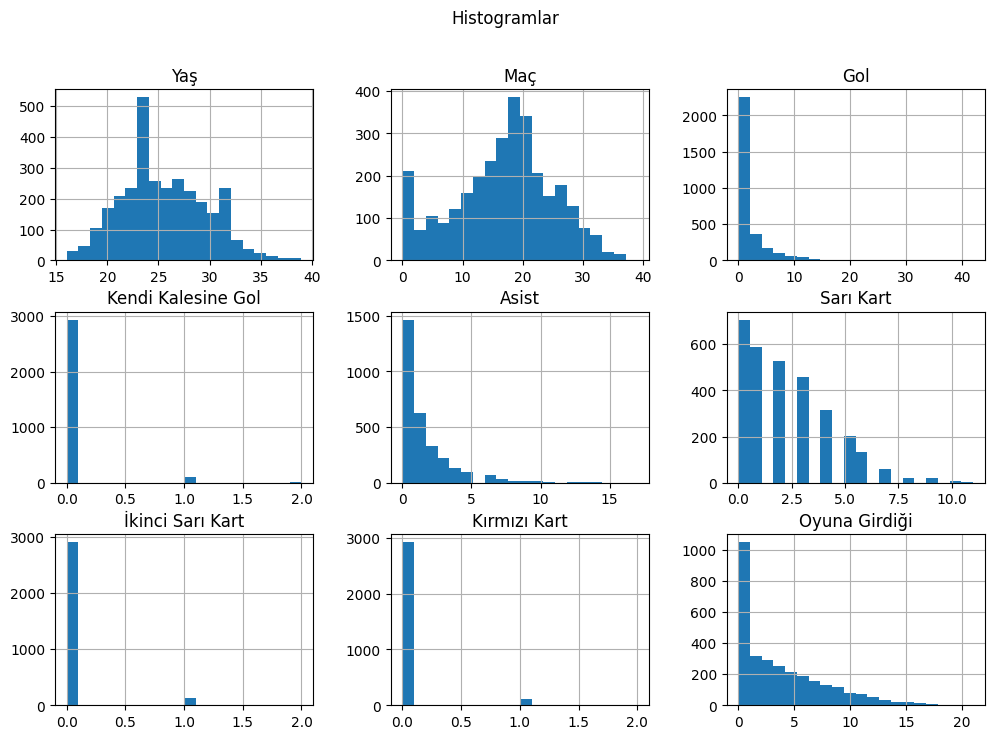

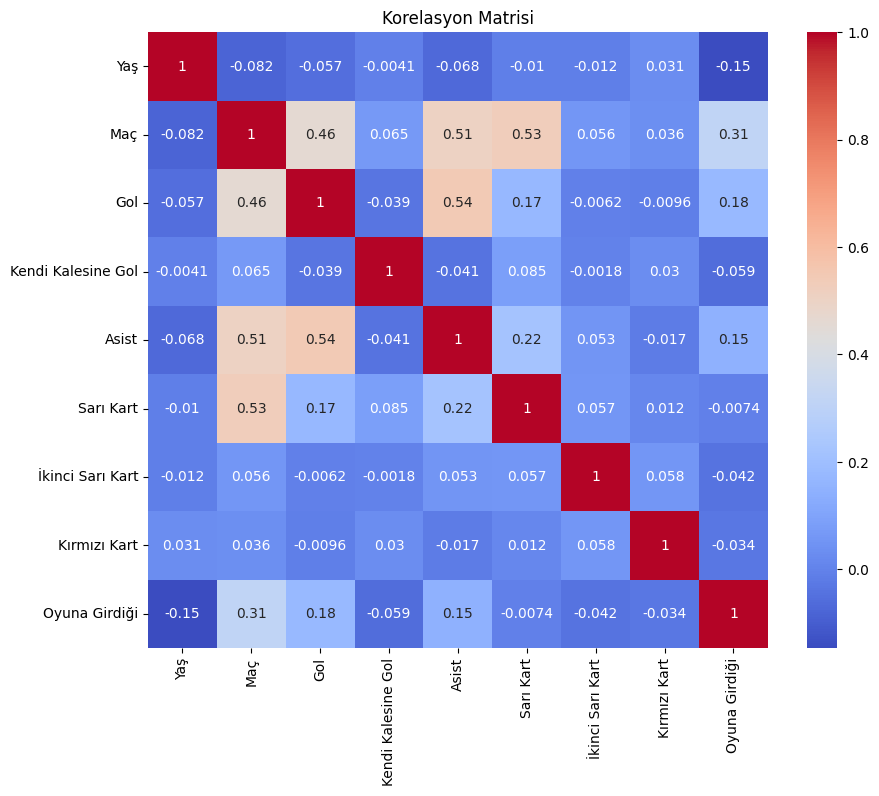

In [12]:
# Histogram
data.hist(bins=20, figsize=(12, 8))
plt.suptitle("Histogramlar")
plt.show()

# Korelasyon matrisi
# Sadece sayısal sütunları seçme
numeric_data = data.select_dtypes(include=["float64", "int64"])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()


In [20]:
X = data.drop('Piyasa Değeri', axis=1)  # Bağımsız değişkenler (features)
y = data['Piyasa Değeri']  # Bağımlı değişken (target)

# Eğitim-Test ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nVeri başarıyla eğitim ve test setlerine ayrıldı!")
print("X_train şekli:", X_train.shape)
print("X_test şekli:", X_test.shape)
print("y_train şekli:", y_train.shape)
print("y_test şekli:", y_test.shape)



Veri başarıyla eğitim ve test setlerine ayrıldı!
X_train şekli: (2432, 11)
X_test şekli: (608, 11)
y_train şekli: (2432,)
y_test şekli: (608,)


In [19]:
from xgboost import XGBRegressor


def categorize_positions(position):
    """
    Futbol pozisyonlarını ana kategorilere ayırır.
    """
    position = position.lower()

    # Hücum pozisyonları
    if any(pos in position for pos in ['santrafor', 'forvet']):
        return 'Forvet'
    elif any(pos in position for pos in ['kanat']):
        return 'Kanat'
    elif 'on numara' in position:
        return 'Ofansif Orta Saha'

    # Orta saha pozisyonları
    elif any(pos in position for pos in ['merkez orta saha', 'ön libero']):
        return 'Merkez Orta Saha'
    elif any(pos in position for pos in ['defansif orta saha']):
        return 'Defansif Orta Saha'

    # Defans pozisyonları
    elif any(pos in position for pos in ['stoper', 'defans']):
        return 'Stoper'
    elif any(pos in position for pos in ['bek']):
        return 'Bek'

    # Kaleci
    elif 'kaleci' in position:
        return 'Kaleci'

    return 'Diğer'

def clean_market_value(value):
    """
    Piyasa değerini sayısal formata dönüştürür.
    Örnek: '200.00 mil. €' -> 200.0, '900 bin €' -> 0.9
    """
    if pd.isna(value):
        return np.nan
    value = value.lower().replace('€', '').strip()  # Küçük harfe çevir, € işaretini kaldır

    try:
        if 'mil.' in value:  # 'mil. €' durumunu işleme
            value = value.replace('mil.', '').strip()
            return float(value)
        elif 'bin' in value:  # 'bin €' durumunu işleme
            value = value.replace('bin', '').strip()
            return float(value) / 1000  # Bin değerini milyona çevir
        else:  # Eğer farklı bir format varsa
            return float(value)
    except ValueError:
        return np.nan  # Dönüşüm başarısız olursa NaN döndür


def prepare_data_for_training(df):
    """
    Veri setini eğitim için hazırlar.
    """
    # Veri setinin bir kopyasını oluştur
    df = df.copy()

    # Piyasa değerini temizle
    df['Piyasa Değeri'] = df['Piyasa Değeri'].apply(clean_market_value)

    # Pozisyonları kategorize et
    df['Pozisyon_Kategori'] = df['Pozisyon'].apply(categorize_positions)

    # One-hot encoding uygula
    position_dummies = pd.get_dummies(df['Pozisyon_Kategori'], prefix='Pozisyon')
    df = pd.concat([df, position_dummies], axis=1)

    # Kullanılmayacak kolonları çıkar
    columns_to_drop = ['Pozisyon', 'Pozisyon_Kategori', 'Oyuncu', 'Kulüp']
    df = df.drop(columns=columns_to_drop)

    # Kategorik kolonları dönüştür
    categorical_columns = ['Uyruk']
    label_encoders = {}

    for column in categorical_columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Sayısal kolonları ölçeklendir
    numeric_columns = ['Yaş', 'Maç', 'Gol', 'Kendi Kalesine Gol', 'Asist',
                      'Sarı Kart', 'İkinci Sarı Kart', 'Kırmızı Kart', 'Oyuna Girdiği']

    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df, label_encoders, scaler

def train_and_evaluate_models(df, models, test_size=0.2, random_state=42):
    """
    Modelleri eğitir ve değerlendirir.
    """
    # Veriyi hazırla
    df_prepared, label_encoders, scaler = prepare_data_for_training(df)

    # Hedef değişkeni ayır (Piyasa Değeri)
    y = df_prepared['Piyasa Değeri']
    X = df_prepared.drop('Piyasa Değeri', axis=1)

    # Eğitim ve test setlerini ayır
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Modelleri eğit ve değerlendir
    results = {}
    for name, model in models.items():
        # Modeli eğit
        model.fit(X_train, y_train)

        # Test verisiyle tahmin yap
        y_pred = model.predict(X_test)

        # Performans metriklerini hesapla
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_test - y_pred))
        r2 = r2_score(y_test, y_pred)  # Yeni eklenen satır
        accuracy_percentage = r2 * 100  # Yüzdelik değere çevirme

        results[name] = {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'accuracy': accuracy_percentage,  # Yeni eklenen
            'model': model
        }

        print(f"\n{name} Model Performansı:")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Doğruluk Oranı: %{accuracy_percentage:.2f}")  # Yeni eklenen satır
    return results, label_encoders, scaler



# Veri setini yükle
df = pd.read_csv('player_table_multiple_leagues.csv')

# Modelleri tanımla
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVR': SVR()
}

# Modelleri eğit ve değerlendir
results, label_encoders, scaler = train_and_evaluate_models(df, models)


Random Forest Model Performansı:
Mean Squared Error (MSE): 91.58
Root Mean Squared Error (RMSE): 9.57
Mean Absolute Error (MAE): 3.96
Doğruluk Oranı: %77.76

XGBoost Model Performansı:
Mean Squared Error (MSE): 80.86
Root Mean Squared Error (RMSE): 8.99
Mean Absolute Error (MAE): 4.12
Doğruluk Oranı: %80.36

Linear Regression Model Performansı:
Mean Squared Error (MSE): 269.44
Root Mean Squared Error (RMSE): 16.41
Mean Absolute Error (MAE): 10.66
Doğruluk Oranı: %34.56

Decision Tree Model Performansı:
Mean Squared Error (MSE): 178.84
Root Mean Squared Error (RMSE): 13.37
Mean Absolute Error (MAE): 4.41
Doğruluk Oranı: %56.56

SVR Model Performansı:
Mean Squared Error (MSE): 400.14
Root Mean Squared Error (RMSE): 20.00
Mean Absolute Error (MAE): 9.48
Doğruluk Oranı: %2.81
